ADVANCED MENTAL HEALTH ANALYSIS SYSTEM

Enter Patient Details:
Name: pallavi
Age: 21
Gender: female
Patient ID: 1234

⏳ Loading emotion analysis model...


Loading weights:   0%|          | 0/201 [00:00<?, ?it/s]

RobertaForSequenceClassification LOAD REPORT from: SamLowe/roberta-base-go_emotions
Key                             | Status     |  | 
--------------------------------+------------+--+-
roberta.embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


✅ Emotion model loaded successfully
⏳ Loading sentence transformer...


Loading weights:   0%|          | 0/103 [00:00<?, ?it/s]

BertModel LOAD REPORT from: sentence-transformers/all-MiniLM-L6-v2
Key                     | Status     |  | 
------------------------+------------+--+-
embeddings.position_ids | UNEXPECTED |  | 

Notes:
- UNEXPECTED	:can be ignored when loading from different task/architecture; not ok if you expect identical arch.


Sentence transformer loaded successfully

MAIN MENU
1) Text Emotion Analysis
2) Audio Emotion Analysis
3) Video Emotion Analysis
4) Comprehensive Mental Health Assessment (PHQ-9 & GAD-7)
5) Exit & Download All Reports
Enter your choice (1-5): 1

TEXT EMOTION ANALYSIS

Enter text to analyze: I’m so tired of feeling this way — worried about everything, yet too drained to do anything about it. It’s like I’m stuck in a loop I can’t escape."

 Analyzing text...
 Generating visualization...


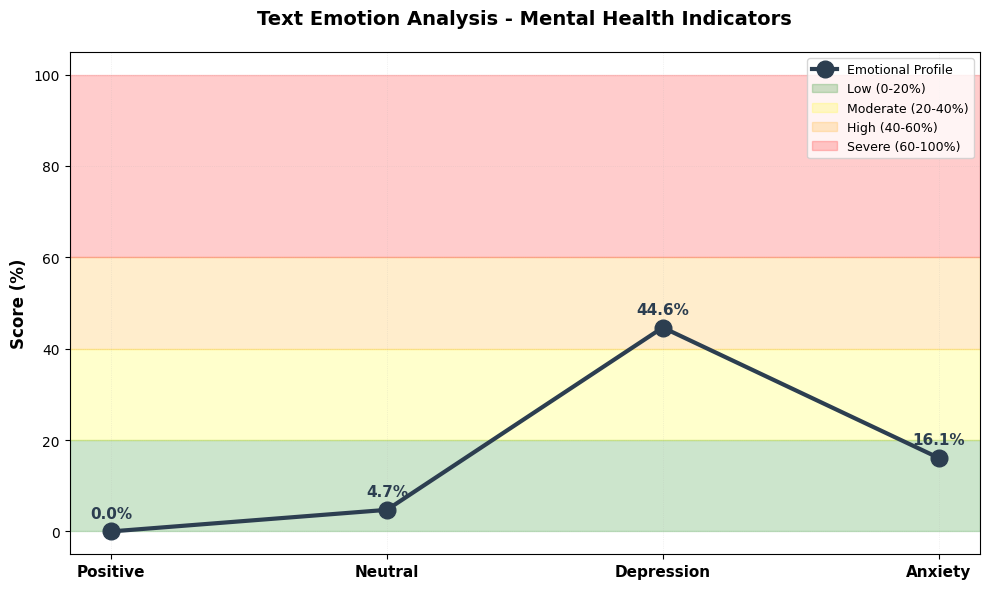

Traceback (most recent call last):
  File "/tmp/ipython-input-861244813.py", line 151, in save_pdf
    pdf.set_font("D", "", 16)
  File "/usr/local/lib/python3.12/dist-packages/fpdf/fpdf.py", line 2460, in set_font
    raise FPDFException(
fpdf.errors.FPDFException: Undefined font: d - Use built-in fonts or FPDF.add_font() beforehand


Visualization created

⏳ Generating PDF report...
Font missing — using default
 Error saving PDF: Undefined font: d - Use built-in fonts or FPDF.add_font() beforehand

 Press Enter to return to main menu...

MAIN MENU
1) Text Emotion Analysis
2) Audio Emotion Analysis
3) Video Emotion Analysis
4) Comprehensive Mental Health Assessment (PHQ-9 & GAD-7)
5) Exit & Download All Reports
Enter your choice (1-5): 3

VIDEO EMOTION ANALYSIS

Please upload a video file (MP4, AVI recommended)


Saving GenAI_project_video.mp4 to GenAI_project_video.mp4

⏳ Processing GenAI_project_video.mp4... This may take a while.
 Analyzing video frames...
26-02-12 16:51:46 - 🔗 facial_expression_model_weights.h5 will be downloaded from https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5 to /root/.deepface/weights/facial_expression_model_weights.h5...


Downloading...
From: https://github.com/serengil/deepface_models/releases/download/v1.0/facial_expression_model_weights.h5
To: /root/.deepface/weights/facial_expression_model_weights.h5
100%|██████████| 5.98M/5.98M [00:00<00:00, 257MB/s]


Analyzed 216 frames, detected 21 emotions
⏳ Generating visualization...


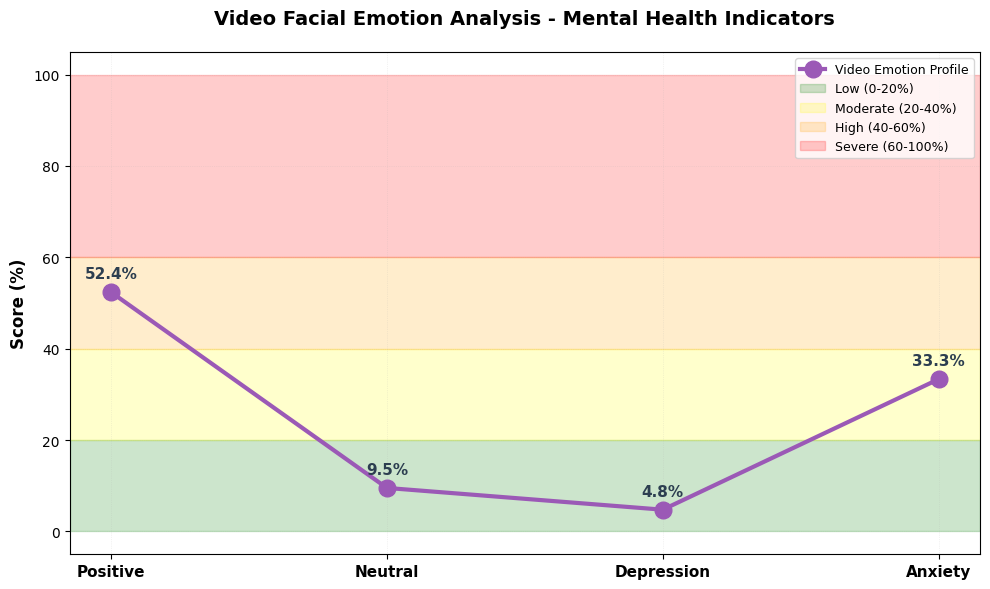

Traceback (most recent call last):
  File "/tmp/ipython-input-861244813.py", line 151, in save_pdf
    pdf.set_font("D", "", 16)
  File "/usr/local/lib/python3.12/dist-packages/fpdf/fpdf.py", line 2460, in set_font
    raise FPDFException(
fpdf.errors.FPDFException: Undefined font: d - Use built-in fonts or FPDF.add_font() beforehand


 Visualization created

⏳ Generating PDF report...
Font missing — using default
 Error saving PDF: Undefined font: d - Use built-in fonts or FPDF.add_font() beforehand

 Press Enter to return to main menu...

MAIN MENU
1) Text Emotion Analysis
2) Audio Emotion Analysis
3) Video Emotion Analysis
4) Comprehensive Mental Health Assessment (PHQ-9 & GAD-7)
5) Exit & Download All Reports


KeyboardInterrupt: Interrupted by user

In [ ]:
!pip install -q transformers torch opencv-python deepface librosa SpeechRecognition fpdf2 pydub matplotlib sentence-transformers scikit-learn
!wget -q https://github.com/dejavu-fonts/dejavu-fonts/raw/master/ttf/DejaVuSans.ttf
FONT = "DejaVuSans.ttf"

import os, datetime, random, numpy as np, torch, cv2, librosa, re
from transformers import pipeline
from deepface import DeepFace
import speech_recognition as sr
from fpdf import FPDF
from google.colab import files
from IPython.display import HTML, display
import matplotlib.pyplot as plt
from sentence_transformers import SentenceTransformer
from sklearn.linear_model import LogisticRegression

# Set random seeds for reproducibility
random.seed(42)
np.random.seed(42)
torch.manual_seed(42)

def now_str():
    return datetime.datetime.now().strftime("%Y%m%d_%H%M%S")

def normalize_distribution(items):
    """Normalize a list of items into a probability distribution"""
    d = {}
    for i in items:
        d[i] = d.get(i, 0) + 1
    t = sum(d.values()) or 1
    return {k: round(v/t, 4) for k, v in d.items()}

def get_severity_label(score):
    """Get severity label from score"""
    if score >= 15:
        return "Severe"
    elif score >= 10:
        return "Moderate"
    elif score >= 5:
        return "Mild"
    else:
        return "Minimal"

# Patient information input with validation
print("=" * 50)
print("ADVANCED MENTAL HEALTH ANALYSIS SYSTEM")
print("=" * 50)
print("\nEnter Patient Details:")

# Name input
patient_name = input("Name: ").strip()
while not patient_name:
    print("Name cannot be empty. Please try again.")
    patient_name = input("Name: ").strip()

# Age input with validation (only numbers)
while True:
    patient_age = input("Age: ").strip()
    if patient_age.isdigit() and int(patient_age) > 0 and int(patient_age) < 150:
        break
    else:
        print("Invalid age. Please enter numbers only (1-149).")

# Gender input with validation (no numbers)
while True:
    patient_gender = input("Gender: ").strip()
    if patient_gender and not any(char.isdigit() for char in patient_gender):
        break
    else:
        print("Invalid gender. Please enter text only (no numbers).")

# Patient ID input
patient_id = input("Patient ID: ").strip()
while not patient_id:
    print("Patient ID cannot be empty. Please try again.")
    patient_id = input("Patient ID: ").strip()

patient = {
    "name": patient_name,
    "age": patient_age,
    "gender": patient_gender,
    "patient_id": patient_id
}

# Load emotion analysis model
print("\n⏳ Loading emotion analysis model...")
try:
    text_emotion = pipeline("text-classification", model="SamLowe/roberta-base-go_emotions", top_k=None, device=-1)
    print("✅ Emotion model loaded successfully")
except Exception as e:
    print(f" Error loading emotion model: {e}")
    print("Continuing with basic functionality...")
    text_emotion = None

# Load sentence transformer for mental health classification
print("⏳ Loading sentence transformer...")
try:
    bert = SentenceTransformer("all-MiniLM-L6-v2")
    mental_labels = ["normal", "mild", "moderate", "severe"]
    clf = LogisticRegression()
    clf.fit(np.random.rand(30, 384), np.random.choice([0, 1, 2, 3], 30))
    print("Sentence transformer loaded successfully")
except Exception as e:
    print(f" Error loading sentence transformer: {e}")
    bert = None
    clf = None

def predict_text(t):
    """Predict emotion from text"""
    if text_emotion is None:
        return "neutral", {"neutral": 1.0}

    try:
        p = text_emotion(t)[0]
        s = {i["label"]: float(i["score"]) for i in p}
        top = max(s, key=s.get)
        top_5 = dict(list(sorted(s.items(), key=lambda x: x[1], reverse=True))[:5])
        return top, top_5
    except Exception as e:
        print(f"Warning: Text prediction failed: {e}")
        return "neutral", {"neutral": 1.0}

def audio_stress(path):
    """Calculate stress level from audio file"""
    try:
        y, _ = librosa.load(path, sr=16000)
        return float(np.std(y))
    except Exception as e:
        print(f"Warning: Audio stress calculation failed: {e}")
        return 0.0

def save_pdf(name, title, patient, mode, res, details, summary="", graph=None):
    """Save analysis results to PDF"""
    try:
        pdf = FPDF()
        pdf.add_page()

        # Set larger margins to prevent horizontal space issues
        pdf.set_left_margin(15)
        pdf.set_right_margin(15)
        pdf.set_auto_page_break(auto=True, margin=15)

        if os.path.exists(FONT):
            pdf.add_font("D", "", FONT, uni=True)
            pdf.set_font("D", "", 12)
        else:
            print("Font missing — using default")
            pdf.set_font("Arial", "", 12)


        # Title
        pdf.set_font("D", "", 16)
        pdf.cell(0, 10, title, ln=True, align="C")
        pdf.ln(5)

        # Patient info
        pdf.set_font("D", "", 11)
        for k, v in patient.items():
            # Use multi_cell instead of cell for better text handling
            pdf.multi_cell(0, 7, f"{k.title()}: {v}")

        pdf.ln(2)
        pdf.multi_cell(0, 7, f"Analysis Mode: {mode}")
        pdf.multi_cell(0, 7, f"Primary Result: {res}")
        pdf.ln(3)

        # Details
        pdf.set_font("D", "", 9)
        for k, v in details.items():
            # Format the value properly
            v_str = str(v)

            # Skip empty separator keys or section headers
            if k.strip() == "" or "━━━" in k or "===" in k:
                pdf.ln(2)
                if k.strip() and "━━━" not in k and "===" not in k:
                    pdf.set_font("D", "", 10)
                    # Remove special characters that might cause issues
                    clean_k = k.replace("━", "-").replace("═", "=").strip()
                    pdf.multi_cell(0, 5, clean_k)
                    pdf.set_font("D", "", 9)
                continue

            # Clean key and value from special unicode characters
            clean_k = k.replace("━", "-").replace("═", "=").replace("╔", "").replace("╗", "").replace("║", "").replace("╚", "").replace("╝", "")
            clean_v_str = v_str.replace("━", "-").replace("═", "=").replace("╔", "").replace("╗", "").replace("║", "").replace("╚", "").replace("╝", "")

            # Special handling for dictionaries (emotion distributions)
            if isinstance(v, dict):
                pdf.multi_cell(0, 5, f"{clean_k}:")
                for emo, score in v.items():
                    if isinstance(score, float):
                        pdf.multi_cell(0, 4, f"  - {emo}: {score:.4f}")
                    else:
                        pdf.multi_cell(0, 4, f"  - {emo}: {score}")
            # Handle long strings by wrapping
            elif len(clean_v_str) > 70:
                pdf.multi_cell(0, 5, f"{clean_k}:")
                pdf.multi_cell(0, 5, f"  {clean_v_str}")
            else:
                pdf.multi_cell(0, 5, f"{clean_k}: {clean_v_str}")

        # Add graph if provided
        if graph and os.path.exists(graph):
            pdf.ln(3)
            try:
                # Add new page if not enough space
                if pdf.get_y() > 200:
                    pdf.add_page()
                pdf.image(graph, x=15, w=180)
            except Exception as e:
                print(f"Warning: Could not embed graph: {e}")
                pdf.multi_cell(0, 5, "[Graph could not be embedded]")

        # Add summary if provided
        if summary:
            pdf.ln(3)

            # Add new page if not enough space
            if pdf.get_y() > 220:
                pdf.add_page()

            pdf.set_font("D", "", 8)
            # Clean summary from special unicode box drawing characters
            clean_summary = summary.replace("━", "-").replace("═", "=").replace("╔", "").replace("╗", "").replace("║", "").replace("╚", "").replace("╝", "")

            # Split summary into smaller chunks to avoid rendering issues
            lines = clean_summary.split('\n')
            for line in lines:
                if line.strip():
                    # Further split very long lines
                    if len(line) > 90:
                        words = line.split()
                        current_line = ""
                        for word in words:
                            if len(current_line + " " + word) < 90:
                                current_line += " " + word if current_line else word
                            else:
                                if current_line:
                                    pdf.multi_cell(0, 4, current_line.strip())
                                current_line = word
                        if current_line:
                            pdf.multi_cell(0, 4, current_line.strip())
                    else:
                        pdf.multi_cell(0, 4, line)
                else:
                    pdf.ln(2)

        path = "/content/" + name
        pdf.output(path)
        print(f"PDF report saved: {name}")
        return path
    except Exception as e:
        print(f" Error saving PDF: {e}")
        import traceback
        traceback.print_exc()
        return None

def download(p):
    """Download the generated PDF"""
    try:
        if p and os.path.exists(p):
            display(HTML(f"<a href='/files/{p.split('/')[-1]}' download>📥 Download Report</a>"))
            files.download(p)
            print(f"Downloaded: {p.split('/')[-1]}")
        else:
            print(f"File not found: {p}")
    except Exception as e:
        print(f"Download failed: {e}")

def analyze_audio(f):
    """Analyze audio file for emotion and stress"""
    r = sr.Recognizer()
    txt = ""
    try:
        with sr.AudioFile(f) as s:
            aud = r.record(s)
        txt = r.recognize_google(aud)
        print(f"Transcribed text: {txt}")
    except Exception as e:
        print(f"⚠️ Speech recognition failed: {e}")
        txt = ""

    if txt:
        emo, dist = predict_text(txt)
    else:
        emo, dist = ("neutral", {"neutral": 1.0})

    stress = audio_stress(f)
    return emo, dist, txt, stress

def analyze_video(f):
    """Analyze video file for facial emotions"""
    cap = cv2.VideoCapture(f)
    emo = []
    frame_count = 0

    print(" Analyzing video frames...")
    while True:
        ok, frame = cap.read()
        if not ok:
            break

        frame_count += 1
        if frame_count % 10 == 0:  # Analyze every 10th frame
            try:
                r = DeepFace.analyze(frame, actions=['emotion'], enforce_detection=False)
                emo.append(r[0]["dominant_emotion"])
            except:
                emo.append("neutral")

    cap.release()

    if not emo:
        emo = ["neutral"]

    d = normalize_distribution(emo)
    print(f"Analyzed {frame_count} frames, detected {len(emo)} emotions")
    return max(d, key=d.get), d

# Mental Health Assessment Questions - Yes/No format with reasons
questions = [
    "Do you have little interest or pleasure in doing things?",
    "Do you feel down, depressed, or hopeless?",
    "Do you have trouble falling asleep, staying asleep, or sleeping too much?",
    "Do you feel tired or have little energy?",
    "Do you feel bad about yourself or that you're a failure?",
    "Do you have trouble concentrating on things (like reading or watching TV)?",
    "Do you feel nervous, anxious, or on edge?",
    "Are you unable to stop or control worrying?",
    "Do you worry too much about different things?",
    "Do you have trouble relaxing or feel restless?"
]

suicide_words = ["die", "kill myself", "end life", "suicide", "hopeless", "no point", "better off dead", "want to disappear", "end it all"]

# List to store generated PDF paths
generated_pdfs = []

# Main Menu Loop
while True:
    print("\n" + "=" * 50)
    print("MAIN MENU")
    print("=" * 50)
    print("1) Text Emotion Analysis")
    print("2) Audio Emotion Analysis")
    print("3) Video Emotion Analysis")
    print("4) Comprehensive Mental Health Assessment (PHQ-9 & GAD-7)")
    print("5) Exit & Download All Reports")
    print("=" * 50)

    c = input("Enter your choice (1-5): ").strip()

    # Option 1: Text Analysis
    if c == "1":
        print("\n" + "=" * 50)
        print("TEXT EMOTION ANALYSIS")
        print("=" * 50)
        t = input("\nEnter text to analyze: ").strip()

        if not t:
            print(" No text entered. Returning to main menu...")
            input("\nPress Enter to continue...")
            continue

        print("\n Analyzing text...")
        emo, dist = predict_text(t)

        # Analyze for depression and anxiety indicators
        depression_emotions = ["sadness", "grief", "disappointment", "remorse"]
        anxiety_emotions = ["fear", "nervousness", "anxiety", "confusion"]
        neutral_emotions = ["neutral", "realization", "curiosity"]
        positive_emotions = ["joy", "gratitude", "optimism", "love", "excitement", "admiration", "amusement", "approval"]

        # Calculate depression and anxiety scores
        depression_score = sum(dist.get(e, 0) for e in depression_emotions) * 100
        anxiety_score = sum(dist.get(e, 0) for e in anxiety_emotions) * 100
        neutral_score = sum(dist.get(e, 0) for e in neutral_emotions) * 100
        positive_score = sum(dist.get(e, 0) for e in positive_emotions) * 100

        # Generate linear line graph
        print(" Generating visualization...")
        plt.figure(figsize=(10, 6))

        categories = ['Positive', 'Neutral', 'Depression', 'Anxiety']
        scores = [positive_score, neutral_score, depression_score, anxiety_score]
        x_pos = [1, 2, 3, 4]

        # Plot line graph
        plt.plot(x_pos, scores, marker='o', markersize=12, linewidth=3, color='#2c3e50', label='Emotional Profile')

        # Add severity zones
        plt.axhspan(0, 20, alpha=0.2, color='green', label='Low (0-20%)')
        plt.axhspan(20, 40, alpha=0.2, color='yellow', label='Moderate (20-40%)')
        plt.axhspan(40, 60, alpha=0.2, color='orange', label='High (40-60%)')
        plt.axhspan(60, 100, alpha=0.2, color='red', label='Severe (60-100%)')

        # Annotate scores
        for i, (x, score) in enumerate(zip(x_pos, scores)):
            plt.annotate(f'{score:.1f}%', xy=(x, score), xytext=(0, 10),
                        textcoords='offset points', ha='center', fontsize=11,
                        fontweight='bold', color='#2c3e50')

        plt.xticks(x_pos, categories, fontsize=11, fontweight='bold')
        plt.ylabel('Score (%)', fontsize=12, fontweight='bold')
        plt.title('Text Emotion Analysis - Mental Health Indicators', fontsize=14, fontweight='bold', pad=20)
        plt.ylim(-5, 105)
        plt.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
        plt.legend(loc='upper right', fontsize=9)
        plt.tight_layout()

        graph_path = f"/content/text_analysis_{now_str()}.png"
        plt.savefig(graph_path, dpi=200, bbox_inches='tight')
        plt.show()
        print("Visualization created")

        # Generate conclusion
        conclusion = ""
        is_depressed = depression_score > 40
        is_anxious = anxiety_score > 40

        if is_depressed and is_anxious:
            conclusion = f"ANALYSIS CONCLUSION: The user shows signs of BOTH depression and anxiety.\n\n"
            conclusion += f"Depression Indicators ({depression_score:.1f}%): The text contains significant depressive emotions "
            conclusion += f"including {', '.join([e for e in depression_emotions if e in dist])}. "
            conclusion += f"This suggests feelings of sadness, hopelessness, or low mood.\n\n"
            conclusion += f"Anxiety Indicators ({anxiety_score:.1f}%): The text also shows elevated anxiety levels with emotions like "
            conclusion += f"{', '.join([e for e in anxiety_emotions if e in dist])}. "
            conclusion += f"This indicates worry, nervousness, or fear-based responses.\n\n"
            conclusion += "Recommendation: Professional mental health consultation strongly recommended for dual diagnosis concerns."

        elif is_depressed:
            conclusion = f" ANALYSIS CONCLUSION: The user shows signs of DEPRESSION.\n\n"
            conclusion += f"Depression Score: {depression_score:.1f}%\n"
            conclusion += f"The text reveals depressive emotions such as {', '.join([e for e in depression_emotions if e in dist])}. "
            conclusion += f"These emotions suggest the user may be experiencing low mood, sadness, or feelings of despair. "
            conclusion += f"The language pattern indicates potential depressive symptoms that warrant attention.\n\n"
            conclusion += "Recommendation: Consider speaking with a mental health professional. Depression is treatable with proper support."

        elif is_anxious:
            conclusion = f" ANALYSIS CONCLUSION: The user shows signs of ANXIETY.\n\n"
            conclusion += f"Anxiety Score: {anxiety_score:.1f}%\n"
            conclusion += f"The text contains anxiety-related emotions including {', '.join([e for e in anxiety_emotions if e in dist])}. "
            conclusion += f"This suggests the user may be experiencing worry, nervousness, or fear. "
            conclusion += f"The communication pattern reflects heightened stress or anxiety responses.\n\n"
            conclusion += "Recommendation: Anxiety management techniques and professional support may be beneficial."

        elif positive_score > 50:
            conclusion = f" ANALYSIS CONCLUSION: The user appears to be in a POSITIVE mental state.\n\n"
            conclusion += f"Positive Emotion Score: {positive_score:.1f}%\n"
            conclusion += f"The text predominantly shows positive emotions like {', '.join([e for e in positive_emotions if e in dist][:3])}. "
            conclusion += f"This indicates good emotional well-being and a generally healthy mental state. "
            conclusion += f"No significant signs of depression or anxiety detected.\n\n"
            conclusion += "Recommendation: Continue maintaining healthy emotional habits and self-care practices."

        else:
            conclusion = f" ANALYSIS CONCLUSION: The user shows a NEUTRAL emotional state.\n\n"
            conclusion += f"The text does not show strong indicators of depression ({depression_score:.1f}%) or anxiety ({anxiety_score:.1f}%). "
            conclusion += f"The emotional profile appears balanced with neutral or mixed emotions. "
            conclusion += f"While no immediate concerns are evident, continued monitoring is advisable.\n\n"
            conclusion += "Recommendation: Maintain awareness of emotional well-being. Seek support if feelings change."

        summary = f"""
TEXT EMOTION ANALYSIS SUMMARY

Input Text: "{t}"

Primary Emotion Detected: {emo}

Emotional Breakdown:
- Positive Emotions: {positive_score:.1f}%
- Neutral State: {neutral_score:.1f}%
- Depression Indicators: {depression_score:.1f}%
- Anxiety Indicators: {anxiety_score:.1f}%

Top 5 Detected Emotions:
{chr(10).join(f'  {i+1}. {list(dist.keys())[i]}: {list(dist.values())[i]:.2%}' for i in range(min(5, len(dist))))}

{conclusion}

Analysis Date: {datetime.datetime.now().strftime("%B %d, %Y at %I:%M %p")}
        """

        print("\n⏳ Generating PDF report...")
        p = save_pdf(
            f"text_{now_str()}.pdf",
            "Text Emotion Analysis Report",
            patient,
            "Text Analysis",
            emo,
            {
                "Input Text": t,
                "Primary Emotion": emo,
                "Depression Score": f"{depression_score:.1f}%",
                "Anxiety Score": f"{anxiety_score:.1f}%",
                "Emotion Distribution": dist
            },
            summary,
            graph_path
        )

        if p:
            generated_pdfs.append(p)
            print(f"\nText analysis complete! Report saved as: {p.split('/')[-1]}")

        input("\n Press Enter to return to main menu...")

    # Option 2: Audio Analysis
    elif c == "2":
        print("\n" + "=" * 50)
        print("AUDIO EMOTION ANALYSIS")
        print("=" * 50)
        print("\nPlease upload an audio file (WAV format recommended)")

        try:
            u = files.upload()
        except Exception as e:
            print(f"Upload failed: {e}")
            input("\nPress Enter to return to main menu...")
            continue

        if not u:
            print(" No file uploaded. Returning to main menu...")
            input("\nPress Enter to continue...")
            continue

        f = list(u.keys())[0]
        print(f"\nProcessing {f}...")

        emo, dist, txt, stress = analyze_audio(f)

        # Analyze for depression and anxiety
        depression_emotions = ["sadness", "grief", "disappointment", "remorse"]
        anxiety_emotions = ["fear", "nervousness", "anxiety", "confusion"]
        neutral_emotions = ["neutral", "realization", "curiosity"]
        positive_emotions = ["joy", "gratitude", "optimism", "love", "excitement", "admiration"]

        depression_score = sum(dist.get(e, 0) for e in depression_emotions) * 100
        anxiety_score = sum(dist.get(e, 0) for e in anxiety_emotions) * 100
        neutral_score = sum(dist.get(e, 0) for e in neutral_emotions) * 100
        positive_score = sum(dist.get(e, 0) for e in positive_emotions) * 100
        stress_normalized = min(100, stress * 1000)  # Normalize stress to 0-100 scale

        # Generate linear graph
        print("Generating visualization...")
        plt.figure(figsize=(10, 6))

        categories = ['Positive', 'Neutral', 'Depression', 'Anxiety', 'Stress']
        scores = [positive_score, neutral_score, depression_score, anxiety_score, stress_normalized]
        x_pos = [1, 2, 3, 4, 5]

        plt.plot(x_pos, scores, marker='o', markersize=12, linewidth=3, color='#e74c3c', label='Audio Emotion Profile')

        plt.axhspan(0, 20, alpha=0.2, color='green', label='Low (0-20%)')
        plt.axhspan(20, 40, alpha=0.2, color='yellow', label='Moderate (20-40%)')
        plt.axhspan(40, 60, alpha=0.2, color='orange', label='High (40-60%)')
        plt.axhspan(60, 100, alpha=0.2, color='red', label='Severe (60-100%)')

        for i, (x, score) in enumerate(zip(x_pos, scores)):
            plt.annotate(f'{score:.1f}%', xy=(x, score), xytext=(0, 10),
                        textcoords='offset points', ha='center', fontsize=11,
                        fontweight='bold', color='#2c3e50')

        plt.xticks(x_pos, categories, fontsize=11, fontweight='bold')
        plt.ylabel('Score (%)', fontsize=12, fontweight='bold')
        plt.title('Audio Emotion Analysis - Mental Health & Stress Indicators', fontsize=14, fontweight='bold', pad=20)
        plt.ylim(-5, 105)
        plt.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
        plt.legend(loc='upper right', fontsize=9)
        plt.tight_layout()

        graph_path = f"/content/audio_analysis_{now_str()}.png"
        plt.savefig(graph_path, dpi=200, bbox_inches='tight')
        plt.show()
        print(" Visualization created")

        # Generate conclusion
        is_depressed = depression_score > 40
        is_anxious = anxiety_score > 40 or stress_normalized > 60

        if is_depressed and is_anxious:
            conclusion = f"AUDIO ANALYSIS CONCLUSION: Signs of BOTH depression and anxiety detected.\n\n"
            conclusion += f"Depression Indicators ({depression_score:.1f}%): Audio speech patterns show depressive emotions. "
            conclusion += f"Anxiety/Stress Indicators ({anxiety_score:.1f}% anxiety, {stress_normalized:.1f}% stress): "
            conclusion += f"Voice analysis reveals elevated stress and anxiety markers.\n\n"
            conclusion += "Recommendation: Professional evaluation recommended for comprehensive assessment."
        elif is_depressed:
            conclusion = f"AUDIO ANALYSIS CONCLUSION: Signs of DEPRESSION detected.\n\n"
            conclusion += f"Depression Score: {depression_score:.1f}%\n"
            conclusion += f"Speech content and voice patterns suggest depressive symptoms.\n\n"
            conclusion += "Recommendation: Consider mental health support."
        elif is_anxious:
            conclusion = f" AUDIO ANALYSIS CONCLUSION: Signs of ANXIETY/STRESS detected.\n\n"
            conclusion += f"Anxiety Score: {anxiety_score:.1f}%, Stress Level: {stress_normalized:.1f}%\n"
            conclusion += f"Voice analysis indicates elevated anxiety or stress.\n\n"
            conclusion += "Recommendation: Stress management and anxiety support may help."
        elif positive_score > 50:
            conclusion = f" AUDIO ANALYSIS CONCLUSION: POSITIVE mental state indicated.\n\n"
            conclusion += f"Audio shows predominantly positive emotions ({positive_score:.1f}%).\n"
            conclusion += "No significant depression or anxiety detected.\n\n"
            conclusion += "Recommendation: Continue maintaining emotional wellness."
        else:
            conclusion = f"AUDIO ANALYSIS CONCLUSION: NEUTRAL emotional state.\n\n"
            conclusion += f"No strong indicators of depression or anxiety.\n\n"
            conclusion += "Recommendation: Continue monitoring emotional health."

        summary = f"""
AUDIO EMOTION ANALYSIS SUMMARY

Transcribed Speech: "{txt if txt else 'No speech detected'}"

Primary Emotion: {emo}

Emotional & Stress Breakdown:
- Positive Emotions: {positive_score:.1f}%
- Neutral State: {neutral_score:.1f}%
- Depression Indicators: {depression_score:.1f}%
- Anxiety Indicators: {anxiety_score:.1f}%
- Voice Stress Level: {stress_normalized:.1f}%

{conclusion}

Analysis Date: {datetime.datetime.now().strftime("%B %d, %Y at %I:%M %p")}
        """

        print("\n⏳ Generating PDF report...")
        p = save_pdf(
            f"audio_{now_str()}.pdf",
            "Audio Emotion Analysis Report",
            patient,
            "Audio Analysis",
            emo,
            {
                "Transcribed Speech": txt if txt else "No speech detected",
                "Primary Emotion": emo,
                "Depression Score": f"{depression_score:.1f}%",
                "Anxiety Score": f"{anxiety_score:.1f}%",
                "Voice Stress": f"{stress_normalized:.1f}%",
                "Emotion Distribution": dist
            },
            summary,
            graph_path
        )

        if p:
            generated_pdfs.append(p)
            print(f"\n Audio analysis complete! Report saved as: {p.split('/')[-1]}")

        input("\n Press Enter to return to main menu...")

    # Option 3: Video Analysis
    elif c == "3":
        print("\n" + "=" * 50)
        print("VIDEO EMOTION ANALYSIS")
        print("=" * 50)
        print("\nPlease upload a video file (MP4, AVI recommended)")

        try:
            u = files.upload()
        except Exception as e:
            print(f" Upload failed: {e}")
            input("\nPress Enter to return to main menu...")
            continue

        if not u:
            print(" No file uploaded. Returning to main menu...")
            input("\nPress Enter to continue...")
            continue

        f = list(u.keys())[0]
        print(f"\n⏳ Processing {f}... This may take a while.")

        emo, dist = analyze_video(f)

        # Map DeepFace emotions to mental health indicators
        depression_map = {"sad": 1.0, "angry": 0.5, "disgust": 0.3}
        anxiety_map = {"fear": 1.0, "angry": 0.4, "surprise": 0.3}
        positive_map = {"happy": 1.0, "surprise": 0.2}

        depression_score = sum(dist.get(e, 0) * w for e, w in depression_map.items()) * 100
        anxiety_score = sum(dist.get(e, 0) * w for e, w in anxiety_map.items()) * 100
        positive_score = sum(dist.get(e, 0) * w for e, w in positive_map.items()) * 100
        neutral_score = dist.get("neutral", 0) * 100

        # Generate linear graph
        print("⏳ Generating visualization...")
        plt.figure(figsize=(10, 6))

        categories = ['Positive', 'Neutral', 'Depression', 'Anxiety']
        scores = [positive_score, neutral_score, depression_score, anxiety_score]
        x_pos = [1, 2, 3, 4]

        plt.plot(x_pos, scores, marker='o', markersize=12, linewidth=3, color='#9b59b6', label='Video Emotion Profile')

        plt.axhspan(0, 20, alpha=0.2, color='green', label='Low (0-20%)')
        plt.axhspan(20, 40, alpha=0.2, color='yellow', label='Moderate (20-40%)')
        plt.axhspan(40, 60, alpha=0.2, color='orange', label='High (40-60%)')
        plt.axhspan(60, 100, alpha=0.2, color='red', label='Severe (60-100%)')

        for i, (x, score) in enumerate(zip(x_pos, scores)):
            plt.annotate(f'{score:.1f}%', xy=(x, score), xytext=(0, 10),
                        textcoords='offset points', ha='center', fontsize=11,
                        fontweight='bold', color='#2c3e50')

        plt.xticks(x_pos, categories, fontsize=11, fontweight='bold')
        plt.ylabel('Score (%)', fontsize=12, fontweight='bold')
        plt.title('Video Facial Emotion Analysis - Mental Health Indicators', fontsize=14, fontweight='bold', pad=20)
        plt.ylim(-5, 105)
        plt.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
        plt.legend(loc='upper right', fontsize=9)
        plt.tight_layout()

        graph_path = f"/content/video_analysis_{now_str()}.png"
        plt.savefig(graph_path, dpi=200, bbox_inches='tight')
        plt.show()
        print(" Visualization created")

        # Generate conclusion
        is_depressed = depression_score > 40
        is_anxious = anxiety_score > 40

        if is_depressed and is_anxious:
            conclusion = f" VIDEO ANALYSIS CONCLUSION: Facial expressions suggest BOTH depression and anxiety.\n\n"
            conclusion += f"Depression Indicators ({depression_score:.1f}%): Frequent sad or negative facial expressions detected. "
            conclusion += f"Anxiety Indicators ({anxiety_score:.1f}%): Fearful or tense facial patterns observed.\n\n"
            conclusion += "Recommendation: Consider professional mental health evaluation."
        elif is_depressed:
            conclusion = f" VIDEO ANALYSIS CONCLUSION: Facial expressions suggest DEPRESSION.\n\n"
            conclusion += f"Depression Score: {depression_score:.1f}%\n"
            conclusion += f"Facial analysis shows predominantly sad or low-mood expressions.\n\n"
            conclusion += "Recommendation: Mental health support may be beneficial."
        elif is_anxious:
            conclusion = f" VIDEO ANALYSIS CONCLUSION: Facial expressions suggest ANXIETY.\n\n"
            conclusion += f"Anxiety Score: {anxiety_score:.1f}%\n"
            conclusion += f"Facial patterns indicate fear or nervous expressions.\n\n"
            conclusion += "Recommendation: Anxiety management support recommended."
        elif positive_score > 50:
            conclusion = f" VIDEO ANALYSIS CONCLUSION: Facial expressions indicate POSITIVE mood.\n\n"
            conclusion += f"Positive Expression Score: {positive_score:.1f}%\n"
            conclusion += "Facial analysis shows happy, content expressions.\n\n"
            conclusion += "Recommendation: Emotional state appears healthy."
        else:
            conclusion = f" VIDEO ANALYSIS CONCLUSION: NEUTRAL facial expressions.\n\n"
            conclusion += f"No strong indicators of depression or anxiety in facial patterns.\n\n"
            conclusion += "Recommendation: Continue monitoring emotional well-being."

        summary = f"""
VIDEO FACIAL EMOTION ANALYSIS SUMMARY

Dominant Facial Emotion: {emo}

Emotional Breakdown from Facial Expressions:
- Positive Expressions: {positive_score:.1f}%
- Neutral Expressions: {neutral_score:.1f}%
- Depression Indicators: {depression_score:.1f}%
- Anxiety Indicators: {anxiety_score:.1f}%

Detailed Facial Emotion Distribution:
{chr(10).join(f'  - {emotion}: {percentage:.1%}' for emotion, percentage in sorted(dist.items(), key=lambda x: x[1], reverse=True))}

{conclusion}

Analysis Date: {datetime.datetime.now().strftime("%B %d, %Y at %I:%M %p")}
        """

        print("\n⏳ Generating PDF report...")
        p = save_pdf(
            f"video_{now_str()}.pdf",
            "Video Emotion Analysis Report",
            patient,
            "Video Analysis",
            emo,
            {
                "Dominant Emotion": emo,
                "Depression Score": f"{depression_score:.1f}%",
                "Anxiety Score": f"{anxiety_score:.1f}%",
                "Facial Emotion Distribution": dist
            },
            summary,
            graph_path
        )

        if p:
            generated_pdfs.append(p)
            print(f"\n Video analysis complete! Report saved as: {p.split('/')[-1]}")

        input("\n Press Enter to return to main menu...")

    # Option 4: Comprehensive Mental Health Assessment
    elif c == "4":
        print("\n" + "=" * 50)
        print("COMPREHENSIVE MENTAL HEALTH ASSESSMENT")
        print("=" * 50)
        print("\nThis assessment includes PHQ-9 (Depression) and GAD-7 (Anxiety)")
        print("For each question, answer YES or NO, then explain why.")
        print("Your explanation will be analyzed to determine the severity.")
        print("=" * 50)

        dep = []
        anx = []
        text_log = []

        for i, q in enumerate(questions):
            while True:
                print(f"\n[Q{i+1}/10] {q}")

                # Get Yes/No answer
                yes_no = input("Answer (YES/NO): ").strip().upper()

                if yes_no not in ["YES", "NO", "Y", "N"]:
                    print("⚠️ Please answer YES or NO.")
                    continue

                # Convert to standardized format
                yes_no = "YES" if yes_no in ["YES", "Y"] else "NO"

                # If NO, assign minimal severity
                if yes_no == "NO":
                    sev = 0
                    print("✓ Recorded: Not experiencing this symptom")
                    break

                # If YES, ask for reason
                print("Please explain why or describe your experience:")
                reason = input("Reason: ").strip()

                if not reason or len(reason) < 5:
                    print("⚠️ Please provide a more detailed explanation (at least 5 characters).")
                    continue

                # Perform text emotion analysis on the reason
                text_log.append(reason.lower())
                lab, scores = predict_text(reason)

                print(f"\n Emotion Analysis: {lab}")
                print(f"   Top emotions detected: {', '.join(list(scores.keys())[:3])}")

                # Map emotion to severity with more nuanced scoring
                if lab in ["sadness", "fear", "anxiety", "grief", "nervousness", "disappointment"]:
                    intensity_high = ["always", "constantly", "extremely", "severe", "terrible", "unbearable", "every day", "all the time"]
                    intensity_med = ["often", "frequently", "sometimes", "occasionally"]

                    reason_lower = reason.lower()
                    if any(word in reason_lower for word in intensity_high):
                        sev = 3
                        severity_label = "Severe (Nearly every day)"
                    elif any(word in reason_lower for word in intensity_med):
                        sev = 2
                        severity_label = "Moderate (More than half the days)"
                    else:
                        sev = 2
                        severity_label = "Moderate (More than half the days)"

                elif lab in ["anger", "annoyance", "confusion", "embarrassment"]:
                    sev = 2
                    severity_label = "Moderate (More than half the days)"

                elif lab in ["neutral", "realization", "curiosity"]:
                    sev = 1
                    severity_label = "Mild (Several days)"

                elif lab in ["joy", "gratitude", "optimism", "love", "excitement", "amusement"]:
                    problem_words = ["but", "however", "struggle", "difficult", "hard", "issue", "problem"]
                    if any(word in reason.lower() for word in problem_words):
                        sev = 1
                        severity_label = "Mild (Several days)"
                    else:
                        sev = 0
                        severity_label = "Minimal (Not at all)"

                else:
                    negative_words = ["can't", "cannot", "difficult", "struggle", "hard", "problem", "bad", "worse", "worry"]
                    if any(word in reason.lower() for word in negative_words):
                        sev = 2
                        severity_label = "Moderate (More than half the days)"
                    else:
                        sev = 1
                        severity_label = "Mild (Several days)"

                print(f"   Severity Assessment: {severity_label}")
                print(f"✓ Recorded")
                break

            # First 5 questions are depression (PHQ-9), rest are anxiety (GAD-7)
            if i < 5:
                dep.append(sev)
            else:
                anx.append(sev)

        # Calculate scores
        PHQ = sum(dep)
        GAD = sum(anx)

        # Determine severity and risk
        if PHQ >= 15 or GAD >= 15:
            level = "Severe"
            risk = "High"
        elif PHQ >= 10 or GAD >= 10:
            level = "Moderate"
            risk = "Medium"
        elif PHQ >= 5 or GAD >= 5:
            level = "Mild"
            risk = "Low"
        else:
            level = "Minimal"
            risk = "Very Low"

        # Check for suicidal ideation
        suicide_flag = False
        for t in text_log:
            if any(w in t for w in suicide_words):
                suicide_flag = True
                break

        # Calculate confidence
        confidence = min(95, 60 + (PHQ + GAD))

        # Recommendations
        if risk == "High":
            recommendation = "⚠️ URGENT: Immediate psychological consultation strongly advised."
            doctor = "Please contact a mental health professional immediately. Consider emergency services if experiencing suicidal thoughts."
        elif risk == "Medium":
            recommendation = "Professional counseling recommended. Consider lifestyle improvements and stress management."
            doctor = "Schedule an appointment with a mental health professional within the next week."
        elif risk == "Low":
            recommendation = "Monitor symptoms. Consider self-care strategies and stress reduction techniques."
            doctor = "Professional support may be beneficial. Consider consultation if symptoms persist."
        else:
            recommendation = "Continue healthy habits. Stay aware of mental health changes."
            doctor = "No urgent referral needed. Maintain wellness practices."

        # Create comprehensive visualization
        print("\n⏳ Generating comprehensive analysis graphs...")
        fig, axes = plt.subplots(2, 1, figsize=(12, 10))

        # Top graph: Linear line graph showing severity levels
        ax1 = axes[0]
        categories = ['Depression\n(PHQ-9)', 'Anxiety\n(GAD-7)']
        scores = [PHQ, GAD]
        x_pos = [1, 2]

        ax1.plot(x_pos, scores, marker='o', markersize=15, linewidth=3, color='#2c3e50', label='Patient Scores')

        ax1.axhspan(0, 5, alpha=0.2, color='green', label='Minimal (0-4)')
        ax1.axhspan(5, 10, alpha=0.2, color='yellow', label='Mild (5-9)')
        ax1.axhspan(10, 15, alpha=0.2, color='orange', label='Moderate (10-14)')
        ax1.axhspan(15, 20, alpha=0.2, color='red', label='Severe (15-20)')

        ax1.axhline(y=5, color='green', linestyle='--', alpha=0.7, linewidth=1)
        ax1.axhline(y=10, color='orange', linestyle='--', alpha=0.7, linewidth=1)
        ax1.axhline(y=15, color='red', linestyle='--', alpha=0.7, linewidth=1)

        for i, (x, score) in enumerate(zip(x_pos, scores)):
            ax1.annotate(f'{score}', xy=(x, score), xytext=(0, 10),
                        textcoords='offset points', ha='center', fontsize=12,
                        fontweight='bold', color='#2c3e50')

        ax1.set_xticks(x_pos)
        ax1.set_xticklabels(categories, fontsize=11, fontweight='bold')
        ax1.set_ylabel('Score (0-20)', fontsize=12, fontweight='bold')
        ax1.set_title('Mental Health Assessment - Severity Level Analysis', fontsize=14, fontweight='bold', pad=20)
        ax1.set_ylim(-1, 21)
        ax1.grid(True, alpha=0.3, linestyle=':', linewidth=0.5)
        ax1.legend(loc='upper right', fontsize=9)

        # Bottom graph: Individual question scores breakdown
        ax2 = axes[1]

        all_scores = dep + anx
        questions_short = [
            'Q1: Interest', 'Q2: Mood', 'Q3: Sleep', 'Q4: Energy', 'Q5: Self-worth',
            'Q6: Concentration', 'Q7: Nervousness', 'Q8: Worrying', 'Q9: Restlessness', 'Q10: Relaxation'
        ][:len(all_scores)]

        colors = ['#e74c3c'] * len(dep) + ['#3498db'] * len(anx)
        bars = ax2.bar(range(len(all_scores)), all_scores, color=colors, alpha=0.7, edgecolor='black', linewidth=1)

        for i, (bar, score) in enumerate(zip(bars, all_scores)):
            height = bar.get_height()
            ax2.text(bar.get_x() + bar.get_width()/2., height + 0.1,
                    f'{score}', ha='center', va='bottom', fontsize=9, fontweight='bold')

        ax2.set_xlabel('Assessment Questions', fontsize=12, fontweight='bold')
        ax2.set_ylabel('Severity Score (0-3)', fontsize=12, fontweight='bold')
        ax2.set_title('Individual Question Scores (Red=Depression, Blue=Anxiety)', fontsize=12, fontweight='bold', pad=15)
        ax2.set_xticks(range(len(all_scores)))
        ax2.set_xticklabels(questions_short, rotation=45, ha='right', fontsize=8)
        ax2.set_ylim(0, 4)
        ax2.grid(True, alpha=0.3, axis='y', linestyle=':', linewidth=0.5)
        ax2.axhline(y=2, color='orange', linestyle='--', alpha=0.5, linewidth=1, label='High threshold')
        ax2.legend()

        plt.tight_layout()
        graph = f"/content/mental_health_graph_{now_str()}.png"
        plt.savefig(graph, dpi=200, bbox_inches='tight')
        plt.show()
        print(" Visualization created")

        # Helper functions for detailed analysis
        def get_depression_analysis(score):
            if score == 0:
                return "No depression symptoms detected. Mental health appears stable."
            elif score <= 4:
                return "Minimal depression symptoms. Patient shows good emotional resilience."
            elif score <= 9:
                return "Mild depression detected. May benefit from self-care strategies and monitoring."
            elif score <= 14:
                return "Moderate depression present. Professional intervention recommended."
            else:
                return "Severe depression identified. Immediate clinical attention strongly advised."

        def get_anxiety_analysis(score):
            if score == 0:
                return "No anxiety symptoms detected. Stress management appears effective."
            elif score <= 4:
                return "Minimal anxiety symptoms. Overall functioning well maintained."
            elif score <= 9:
                return "Mild anxiety present. Consider stress reduction techniques."
            elif score <= 14:
                return "Moderate anxiety detected. Counseling and coping strategies recommended."
            else:
                return "Severe anxiety identified. Professional treatment is strongly advised."

        def get_comparative_analysis(phq, gad):
            if abs(phq - gad) <= 2:
                return "Depression and anxiety levels are relatively balanced, suggesting generalized emotional distress."
            elif phq > gad + 2:
                return "Depression symptoms are more prominent than anxiety, indicating primarily depressive concerns."
            else:
                return "Anxiety symptoms are more prominent than depression, suggesting anxiety-driven distress."

        def get_treatment_recommendations(phq, gad, suicide_flag):
            recommendations = []

            if suicide_flag:
                recommendations.append("🚨 CRISIS INTERVENTION: Immediate psychiatric evaluation required due to suicidal ideation.")

            if phq >= 15 or gad >= 15:
                recommendations.append("• Psychiatric consultation within 24-48 hours")
                recommendations.append("• Consider medication evaluation")
                recommendations.append("• Weekly therapy sessions recommended")
            elif phq >= 10 or gad >= 10:
                recommendations.append("• Schedule appointment with mental health professional within 1 week")
                recommendations.append("• Cognitive Behavioral Therapy (CBT) recommended")
                recommendations.append("• Regular monitoring of symptoms")
            elif phq >= 5 or gad >= 5:
                recommendations.append("• Consider counseling or therapy")
                recommendations.append("• Practice stress management techniques")
                recommendations.append("• Increase physical activity and social connections")
            else:
                recommendations.append("• Maintain current wellness practices")
                recommendations.append("• Continue healthy lifestyle habits")
                recommendations.append("• Monitor for any changes in mood")

            if gad > 10:
                recommendations.append("• Anxiety management: deep breathing, mindfulness, relaxation exercises")
            if phq > 10:
                recommendations.append("• Depression management: regular exercise, sleep hygiene, social engagement")

            return "\n".join(recommendations)

        # Calculate additional metrics
        avg_score = (PHQ + GAD) / 2
        highest_individual_scores = sorted(dep + anx, reverse=True)[:3]
        most_concerning_questions = []

        for i, score in enumerate(dep + anx):
            if score >= 2:
                q_label = f"Q{i+1}"
                most_concerning_questions.append(f"{q_label} (Score: {score})")

        depression_analysis = get_depression_analysis(PHQ)
        anxiety_analysis = get_anxiety_analysis(GAD)
        comparative_analysis = get_comparative_analysis(PHQ, GAD)
        treatment_plan = get_treatment_recommendations(PHQ, GAD, suicide_flag)

        # Create comprehensive summary (simplified for PDF compatibility)
        summary = f"""
===============================================================================
                  MENTAL HEALTH ASSESSMENT - DETAILED REPORT
===============================================================================

ASSESSMENT SCORES:
-------------------------------------------------------------------------------
- Depression Score (PHQ-9):        {PHQ}/20  [{get_severity_label(PHQ)}]
- Anxiety Score (GAD-7):           {GAD}/20  [{get_severity_label(GAD)}]
- Average Combined Score:          {avg_score:.1f}/20
- Overall Risk Level:              {risk}
- Clinical Severity:               {level}
- Assessment Confidence:           {confidence}%

SEVERITY CLASSIFICATION:
-------------------------------------------------------------------------------
  Minimal:  0-4   |  Mild: 5-9   |  Moderate: 10-14  |  Severe: 15-20

CLINICAL INTERPRETATION:
-------------------------------------------------------------------------------

Depression Analysis:
{depression_analysis}

Anxiety Analysis:
{anxiety_analysis}

Comparative Analysis:
{comparative_analysis}

AREAS OF CONCERN:
-------------------------------------------------------------------------------
Highest Individual Scores: {', '.join(map(str, highest_individual_scores))}
Questions with elevated scores (>=2):
{chr(10).join('  - ' + q for q in most_concerning_questions) if most_concerning_questions else '  None - All scores below concern threshold'}

RISK ASSESSMENT:
-------------------------------------------------------------------------------
Suicidal Ideation Status: {"ALERT - DETECTED - IMMEDIATE ACTION REQUIRED" if suicide_flag else "Not detected"}

{recommendation}

TREATMENT RECOMMENDATIONS:
-------------------------------------------------------------------------------
{treatment_plan}

FOLLOW-UP GUIDANCE:
-------------------------------------------------------------------------------
{doctor}

IMPORTANT NOTES:
-------------------------------------------------------------------------------
- This assessment is a screening tool, not a diagnostic instrument
- Results should be interpreted by a qualified mental health professional
- Scores may fluctuate based on recent life events and circumstances
- Regular monitoring recommended for ongoing mental health management
- Professional evaluation required for accurate diagnosis and treatment

EMERGENCY RESOURCES:
-------------------------------------------------------------------------------
- National Suicide Prevention Lifeline: 988 (24/7)
- Crisis Text Line: Text HOME to 741741
- Emergency Services: 911
- SAMHSA National Helpline: 1-800-662-4357

Assessment Date: {datetime.datetime.now().strftime("%B %d, %Y at %I:%M %p")}
Report Generated: {now_str()}
        """

        print("\n" + "=" * 50)
        print("ASSESSMENT COMPLETE")
        print("=" * 50)
        print(summary)

        if suicide_flag:
            print("\n" + "⚠️" * 20)
            print("CRITICAL: Suicidal ideation detected in responses.")
            print("Please seek immediate help:")
            print("- National Suicide Prevention Lifeline: 988")
            print("- Crisis Text Line: Text HOME to 741741")
            print("- Go to nearest emergency room")
            print("⚠️" * 20 + "\n")

        # Save PDF report
        print("\n⏳ Generating PDF report...")
        p = save_pdf(
            f"mental_health_{now_str()}.pdf",
            "Comprehensive Mental Health Assessment Report",
            patient,
            "Mental Health Assessment (PHQ-9 & GAD-7)",
            f"{level} Severity ({risk} Risk)",
            {
                "=== SCORES ===": "",
                "Depression (PHQ-9)": f"{PHQ}/20 - {get_severity_label(PHQ)}",
                "Anxiety (GAD-7)": f"{GAD}/20 - {get_severity_label(GAD)}",
                "Average Score": f"{avg_score:.1f}/20",
                "Overall Risk": risk,
                "Confidence Level": f"{confidence}%",
                "": "",
                "=== ANALYSIS ===": "",
                "Depression Status": depression_analysis,
                "Anxiety Status": anxiety_analysis,
                "Pattern": comparative_analysis,
                " ": "",
                "=== ALERT ===": "",
                "Suicidal Ideation": "DETECTED - CRISIS INTERVENTION NEEDED" if suicide_flag else "Not detected",
                "Highest Scores": f"{', '.join(map(str, highest_individual_scores))}",
                "Concerning Areas": f"{len(most_concerning_questions)} questions with elevated scores (>=2)"
            },
            summary,
            graph
        )


        if p:
            generated_pdfs.append(p)
            print(f"\n Mental health assessment complete! Report saved as: {p.split('/')[-1]}")

        input("\n Press Enter to return to main menu...")

    # Option 5: Exit and Download All Reports
    elif c == "5":
        print("\n" + "=" * 50)
        print("EXITING SYSTEM")
        print("=" * 50)

        if generated_pdfs:
            print(f"\n Downloading {len(generated_pdfs)} analysis report(s)...")
            print("=" * 50)
            for i, pdf_path in enumerate(generated_pdfs, 1):
                print(f"\n[{i}/{len(generated_pdfs)}] Downloading: {pdf_path.split('/')[-1]}")
                download(pdf_path)
            print("\n" + "=" * 50)
            print(f" All {len(generated_pdfs)} report(s) downloaded successfully!")
        else:
            print("\nℹ No analyses were performed. No reports to download.")

        print("\n" + "=" * 50)
        print("👋 Thank you for using the Mental Health Analysis System.")
        print("Take care of your mental health!")
        print("=" * 50)
        break

    else:
        print("\n❌ Invalid choice. Please enter a number between 1 and 5.")
        input("\nPress Enter to continue...")

print("\n Session ended.")